In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np
import sys
from PIL import Image
from scipy.stats import spearmanr as spr
import time
import ast
import json
import os

In [3]:
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from captum.attr import Saliency, IntegratedGradients, LRP, GuidedBackprop, NoiseTunnel, GuidedGradCam, InputXGradient, DeepLift
from captum.attr import visualization as viz

In [5]:
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image
import mister_ed.utils.pytorch_utils as mister_ed_utils

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])

In [8]:
normalizer = mister_ed_utils.DifferentiableNormalize(mean=data_mean,
                                               std=data_std)

In [9]:
file = open("imagnet_classes.txt", "r")

contents = file.read()
imagenet_classes = ast.literal_eval(contents)

file.close()

print(type(imagenet_classes))

<class 'dict'>


In [10]:
%cd
%cd Robust_Explanations/notebooks

/home/ubuntu
/home/ubuntu/Robust_Explanations/notebooks


In [11]:
img_num=0

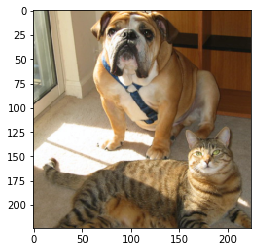

In [12]:
img = load_image(data_mean, data_std, device, "../class_sensitivity/images/catdog{}.jpeg".format(img_num))
plt.imshow(torch_to_image(img, data_mean, data_std))

In [13]:
%cd
%cd darknet

/home/ubuntu
/home/ubuntu/darknet


In [14]:
if len(img.shape) == 4:
        unnorm_img = img.permute(0, 2, 3, 1)
unnorm_img = unnorm_img.contiguous().squeeze().cpu()
unnorm_img = unnorm_img * data_std.reshape(1, 1, 3) + data_mean.reshape(1, 1, 3)
save_image(unnorm_img.permute(2,0,1), "temp_image.jpg")

In [15]:
!./darknet detect cfg/yolov3.cfg yolov3.weights temp_image.jpg | tee output.log

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

Loading weights from yolov3.weights...Done!
temp_image.jpg: Predicted in 21.311061 seconds.
dog: 100%
Bounding Box: Left=58, Top=6, Right=192, Bottom=152
cat: 89%
Bounding Box: Left=33, Top=122, Right=211, Bottom=221
Number of objects found: 2


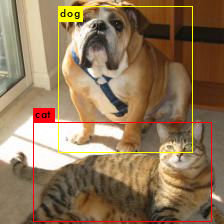

In [16]:
Image.open("predictions.jpg")

In [17]:
with open("output.log", "r") as f:
    lines = f.readlines()
bbox = {}
for l in range(1, len(lines), 2):
    if lines[l].split(":")[0] == "dog" or lines[l].split(":")[0] == "cat":
        box_coords = lines[l+1].split(":")[1].split(",")
        bbox[lines[l].split(":")[0]] = {box_coords[0].strip().split("=")[0]: int(box_coords[0].strip().split("=")[1]),
                               box_coords[1].strip().split("=")[0]: int(box_coords[1].strip().split("=")[1]),
                               box_coords[2].strip().split("=")[0]: int(box_coords[2].strip().split("=")[1]),
                               box_coords[3].strip().split("=")[0]: int(box_coords[3].strip().split("=")[1])}

# box_coords = lines[4].split(":")[1].split(",")
# bbox[lines[3].split(":")[0]] = {box_coords[0].strip().split("=")[0]: int(box_coords[0].strip().split("=")[1]),
#                                box_coords[1].strip().split("=")[0]: int(box_coords[1].strip().split("=")[1]),
#                                box_coords[2].strip().split("=")[0]: int(box_coords[2].strip().split("=")[1]),
#                                box_coords[3].strip().split("=")[0]: int(box_coords[3].strip().split("=")[1])}
print(bbox)

{'dog': {'Left': 58, 'Top': 6, 'Right': 192, 'Bottom': 152}, 'cat': {'Left': 33, 'Top': 122, 'Right': 211, 'Bottom': 221}}


In [18]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()
model_softplus = convert_relu_to_softplus(model, beta=0.8)
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [19]:
sigma = (torch.max(img) - torch.min(img)).item() * 0.2
sigma

0.9070564270019532

In [20]:
model(img).argsort(descending=True)[:,:40]

tensor([[243, 242, 254, 245, 180, 247, 179, 163, 246, 534, 539, 676, 262, 852,
         282, 292, 195, 805, 811, 238, 897, 281, 161, 722, 168, 159, 753, 799,
         234, 204, 841, 155, 434, 789, 201, 208, 225, 251, 202, 898]],
       device='cuda:0')

In [21]:
ind1=243
ind2=282

In [22]:
print(ind1, imagenet_classes[ind1])
print(ind2, imagenet_classes[ind2])

243 bull mastiff
282 tiger cat


In [23]:
inds = list(model(img).argsort(descending=True)[:,:40].squeeze().cpu().numpy())

In [24]:
F.softmax(model(img), dim=1)[0, inds]

tensor([6.7746e-01, 1.6313e-01, 9.0756e-02, 4.1828e-02, 3.6564e-03, 2.3809e-03,
        2.2692e-03, 2.1116e-03, 1.1181e-03, 1.0572e-03, 9.9602e-04, 8.0536e-04,
        7.6388e-04, 6.6164e-04, 6.3140e-04, 5.7628e-04, 5.6918e-04, 5.6629e-04,
        5.1767e-04, 4.4341e-04, 3.6046e-04, 3.0963e-04, 2.9085e-04, 2.5685e-04,
        2.4006e-04, 2.1529e-04, 2.1476e-04, 2.1321e-04, 2.1028e-04, 2.0322e-04,
        2.0140e-04, 1.8432e-04, 1.7132e-04, 1.4944e-04, 1.4935e-04, 1.4920e-04,
        1.4241e-04, 1.3705e-04, 1.2493e-04, 9.3845e-05], device='cuda:0',
       grad_fn=<IndexBackward>)

In [25]:
def unravel_index(
    # to unravel the flatten index to tensor indices
    indices: torch.LongTensor,
    shape: (int, ...),
) -> torch.LongTensor:
    r"""Converts flat indices into unraveled coordinates in a target shape.

    This is a `torch` implementation of `numpy.unravel_index`.

    Args:
        indices: A tensor of (flat) indices, (*, N).
        shape: The targeted shape, (D,).

    Returns:
        The unraveled coordinates, (*, N, D).
    """

    coord = []

    for dim in reversed(shape):
        coord.append(indices % dim)
        indices = indices // dim

    coord = torch.stack(coord[::-1], dim=-1)

    return coord

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


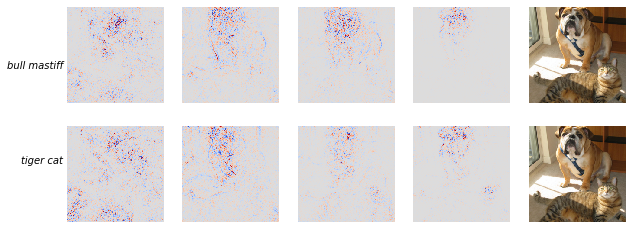

In [26]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
grad_top5_indices={}
sg_top5_indices={}
ug_top5_indices={}
softplus_top5_indices={}
top_features = 20
for i, idx in enumerate([ind1, ind2]): 
    x_expl_grad = get_expl(model, img, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    x_expl_sg = get_expl(model, img, "saliency", desired_index=idx, smooth=True, sigma=sigma, abs_value=False).detach().cpu()
    x_expl_ug = get_expl(model, img, "uniform_grad", desired_index=idx, sigma=sigma, abs_value=False).detach().cpu()
    torch.cuda.empty_cache()

    viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap="coolwarm",
                                 show_colorbar=False,
                                 sign='all',
                                 outlier_perc=2,
                                 fig_size=(4,4), plt_fig_axis=(fig, ax[i,0]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap="coolwarm",
                                 show_colorbar=False,
                                 sign='all',
                                 outlier_perc=2,
                                 fig_size=(4,4), plt_fig_axis=(fig, ax[i,1]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap="coolwarm",
                                 show_colorbar=False,
                                 sign='all',
                                 outlier_perc=2,
                                 fig_size=(4,4), plt_fig_axis=(fig, ax[i,2]), use_pyplot=False)

    x_expl_softplus = get_expl(model_softplus, img, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap="coolwarm",
                                 show_colorbar=False,
                                 sign='all',
                                 outlier_perc=2,
                                 fig_size=(4,4), plt_fig_axis=(fig, ax[i,3]), use_pyplot=False)
    grad_top5_indices[idx] = unravel_index(x_expl_grad.flatten().argsort(descending=True)[:top_features], x_expl_grad.size())
    sg_top5_indices[idx] = unravel_index(x_expl_sg.flatten().argsort(descending=True)[:top_features], x_expl_sg.size())
    ug_top5_indices[idx] = unravel_index(x_expl_ug.flatten().argsort(descending=True)[:top_features], x_expl_ug.size())
    softplus_top5_indices[idx] = unravel_index(x_expl_softplus.flatten().argsort(descending=True)[:top_features], x_expl_softplus.size())

    ax[i,4].imshow(torch_to_image(img, data_mean, data_std))
    for j in range(5):
        ax[i,j].axis('off')
fig.text(0.12, 0.66, imagenet_classes[ind1], style = 'oblique', fontsize = 10, horizontalalignment ='right')
fig.text(0.12, 0.33, imagenet_classes[ind2], style = 'oblique', fontsize = 10, horizontalalignment ='right')
plt.savefig("../Robust_Explanations/class_sensitivity/results/pointing_game_{}.jpg".format(img_num), dpi=300, bbox_inches='tight', pad_inches=0.05);


#### pointing game experiment
Let's see if the top 5 features of the explanation are included in the bounding box.

In [27]:
bbox = {ind1:bbox["dog"],  # dog
        ind2:bbox["cat"]}   # cat
bbox

{243: {'Left': 58, 'Top': 6, 'Right': 192, 'Bottom': 152},
 282: {'Left': 33, 'Top': 122, 'Right': 211, 'Bottom': 221}}

In [28]:
k=0
in_box = {"grad":{},
"sg":{},
"ug":{},
"softplus":{}}
for j , idx in enumerate([ind1, ind2]):
    in_box["grad"][j]=0
    in_box["sg"][j]=0
    in_box["ug"][j]=0
    in_box["softplus"][j]=0
    for k in range(top_features):
        if (((grad_top5_indices[idx][k][2] > bbox[idx]["Top"]) & (grad_top5_indices[idx][k][2] < bbox[idx]["Bottom"])) and 
           ((grad_top5_indices[idx][k][3] > bbox[idx]["Left"]) & (grad_top5_indices[idx][k][3] < bbox[idx]["Right"]))):
            in_box["grad"][j] += 1
        ####################
        if (((sg_top5_indices[idx][k][2] > bbox[idx]["Top"]) & (sg_top5_indices[idx][k][2] < bbox[idx]["Bottom"])) and 
           ((sg_top5_indices[idx][k][3] > bbox[idx]["Left"]) & (sg_top5_indices[idx][k][3] < bbox[idx]["Right"]))):
            in_box["sg"][j] += 1
        ####################
        if (((ug_top5_indices[idx][k][2] > bbox[idx]["Top"]) & (ug_top5_indices[idx][k][2] < bbox[idx]["Bottom"])) and 
           ((ug_top5_indices[idx][k][3] > bbox[idx]["Left"]) & (ug_top5_indices[idx][k][3] < bbox[idx]["Right"]))):
            in_box["ug"][j] += 1
        #####################
        if (((softplus_top5_indices[idx][k][2] > bbox[idx]["Top"]) & (softplus_top5_indices[idx][k][2] < bbox[idx]["Bottom"])) and 
           ((softplus_top5_indices[idx][k][3] > bbox[idx]["Left"]) & (softplus_top5_indices[idx][k][3] < bbox[idx]["Right"]))):
            in_box["softplus"][j] += 1
            

In [29]:
print(in_box)

{'grad': {0: 20, 1: 0}, 'sg': {0: 3, 1: 1}, 'ug': {0: 20, 1: 0}, 'softplus': {0: 20, 1: 0}}


In [30]:
with open("../Robust_Explanations/class_sensitivity/results/in_box_{}.json".format(img_num), "w") as f:
    json.dump(in_box, f)

In [31]:
grad_top5_indices

{243: tensor([[  0,   1,  52,  96],
         [  0,   1,  38, 123],
         [  0,   1,  47,  99],
         [  0,   1,  47,  98],
         [  0,   1,  50,  99],
         [  0,   1,  36, 120],
         [  0,   1,  49,  99],
         [  0,   1,  62, 145],
         [  0,   1,  56, 106],
         [  0,   1,  36, 110],
         [  0,   1,  31, 124],
         [  0,   0,  36, 110],
         [  0,   1,  42, 118],
         [  0,   1,  24, 117],
         [  0,   1,  49,  98],
         [  0,   1,  41, 120],
         [  0,   1,  19, 109],
         [  0,   1,  37, 119],
         [  0,   1,  33, 111],
         [  0,   1,  60, 110]]),
 282: tensor([[  0,   1,  77, 172],
         [  0,   1,  49,  99],
         [  0,   1,  50,  99],
         [  0,   1,  49,  98],
         [  0,   1,  36, 110],
         [  0,   1,  47,  99],
         [  0,   0,  36, 110],
         [  0,   1,  39, 114],
         [  0,   1,  52,  96],
         [  0,   1,  47,  98],
         [  0,   1,  50,  95],
         [  0,   1,  77, 17

#### average results

In [175]:
i = 0
all_results = {"grad":{0:0, 1:0},
"sg":{0: 0, 1:0},
"ug":{0: 0, 1:0},
"softplus":{0: 0, 1:0}}
for f in os.listdir("../Robust_Explanations/class_sensitivity/results"):
    if f.startswith("in_box"):
        i = i+1
        with open("../Robust_Explanations/class_sensitivity/results/"+f, "r") as fp:
            box = json.load(fp)
        for method in ["grad", "sg", "ug", "softplus"]:
            for _ in [0,1]:
                all_results[method][_] += box[method][str(_)]



In [176]:
i

20

In [177]:
{k1: {k2:v2/(20*i) for k2,v2 in v1.items()} for k1,v1 in all_results.items()}

{'grad': {0: 0.605, 1: 0.43},
 'sg': {0: 0.7, 1: 0.3525},
 'ug': {0: 0.665, 1: 0.195},
 'softplus': {0: 0.7275, 1: 0.4175}}

In [133]:
transform_voc = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor()])

# transform_voc = transforms.Compose([transforms.ToTensor()])

voc_val = torchvision.datasets.VOCDetection(root="./data/", image_set="trainval", download=True, transform=transform_voc)

test_loader = torch.utils.data.DataLoader(
        voc_val,
        batch_size=128,
        shuffle=True,
        collate_fn=lambda x: x
    )

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar


In [134]:
voc_val

Dataset VOCDetection
    Number of datapoints: 11540
    Root location: ./data/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

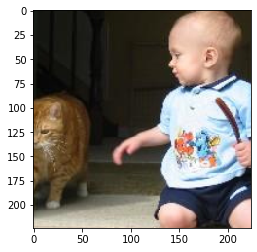

In [9]:
plt.imshow(voc_val[165][0].permute(1,2,0))

In [10]:
jsovoc_val[165][1]

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000660.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '320', 'height': '213', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'person',
    'pose': 'Frontal',
    'truncated': '0',
    'occluded': '0',
    'bndbox': {'xmin': '135', 'ymin': '10', 'xmax': '302', 'ymax': '205'},
    'difficult': '0'},
   {'name': 'cat',
    'pose': 'Frontal',
    'truncated': '0',
    'occluded': '0',
    'bndbox': {'xmin': '48', 'ymin': '82', 'xmax': '117', 'ymax': '192'},
    'difficult': '0'}]}}

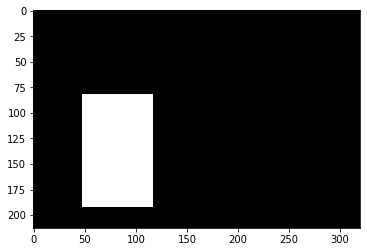

In [11]:
mask=torch.zeros((3,213,320))
mask[:, 82:192, 48: 117] = 1
plt.imshow(mask.permute(1,2,0))

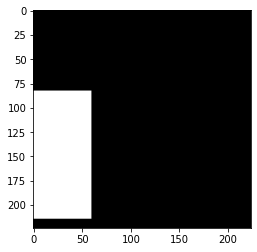

In [12]:
mask = transforms.CenterCrop(224)(transforms.Resize(256)(mask))
plt.imshow(mask.permute(1,2,0))

In [179]:
dataiter = iter(test_loader)
images = next(dataiter)

In [187]:
images = next(dataiter)

In [182]:
selected_objects = set(['bird'
'cat',
'cow',
'dog',
'horse',
'sheep'])

74


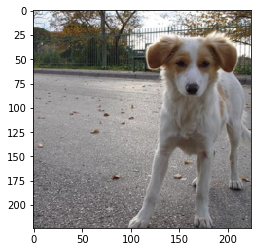

In [188]:
flag = 1
for a in range(128):
#     a = np.random.randint(128)
    objects = images[a][1]["annotation"]["object"]
    if len(objects) == 2:
        if (set([objects[0]["name"], objects[1]["name"]]).issubset(selected_objects)) \
        and objects[0]["name"]!=objects[1]["name"]\
        and ((int(objects[0]["bndbox"]["xmax"]) < int(objects[1]["bndbox"]["xmin"])) |
            (int(objects[1]["bndbox"]["xmax"]) < int(objects[0]["bndbox"]["xmin"]))):
#             flag = 0
            break
plt.imshow(images[a][0].permute(1,2,0))
print(a)

In [195]:
with open("../class_sensitivity/images/image1_annot.json", "w") as f:
    json.dump(images[a][1], f)

In [85]:
resized_bbox = transform_bbox(images[a][1]["annotation"])

In [86]:
resized_bbox

{'sheep': {'hmin': 0, 'hmax': 141, 'wmin': 0, 'wmax': 223},
 'dog': {'hmin': 74, 'hmax': 190, 'wmin': 50, 'wmax': 103}}

In [196]:
save_image(images[a][0], "../../darknet/temp_resize_image.jpg")

In [193]:
%cd ../Robust_Explanations/notebooks/

/home/ubuntu/Robust_Explanations/notebooks


(-0.5, 223.5, 223.5, -0.5)

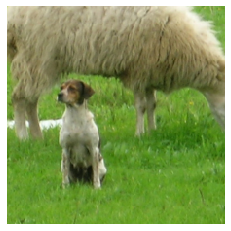

In [88]:
img = normalizer.forward(images[a][0].unsqueeze(0)).to(device)
plt.imshow(torch_to_image(img, data_mean, data_std))
plt.axis('off')

In [ ]:
# fig for the paper
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
for i, idx in enumerate([254, 282]): #dog, cat

    x_expl_softplus = get_expl(model_softplus, img, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap="coolwarm",
                                 show_colorbar=False,
                                 sign='all',
                                 outlier_perc=2,
                                 fig_size=(4,4), plt_fig_axis=(fig, ax[i,0]), use_pyplot=False)
    
    ax[i,1].imshow(Image.open("predictions.jpg"))
    for j in range(2):
        ax[i,j].axis('off')
fig.text(0.12, 0.66, 'Dog', style = 'oblique', fontsize = 10, horizontalalignment ='right')
fig.text(0.12, 0.33, 'Tiger cat', style = 'oblique', fontsize = 10, horizontalalignment ='right')
plt.savefig("pointing_game.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [ ]:
unravel_index(a.flatten().argsort(descending=True)[:3], a.size())

In [ ]:
a.flatten().argsort(descending=True)